In [1]:
import numpy as np
import pandas as pd
import urllib
import sklearn
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [2]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

The capturing period for network traffic ran from 09:00 Monday to 17:00 on Friday. Capturing files are arranged by day and each day corresponds to a particular attack profile. The files are concatenated together into one file using the code below

In [3]:
#path = r'C:\Users\toybi\Desktop\Project\security 2017\MachineLearningCVE' # use your path
#all_files = glob.glob(path + "/*.csv")
#li = []
#for filename in all_files:
#    df = pd.read_csv(filename, index_col=None, header=0)
#    li.append(df)
#frame = pd.concat(li, axis=0, ignore_index=True)
#frame.to_csv("combined.csv", index=False, encoding='utf-8-sig')

In [4]:
df = pd.read_csv('combined.csv')

In [8]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [9]:
df.shape

(2830743, 79)

In [5]:
label_array = df[' Label'].unique()

In [11]:
label_array

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

In [13]:
df[' Label'].value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [6]:
count = 0
for i in label_array:
  df.loc[(df[' Label']== i),' Label']= count
  print (i , count )
  count += 1

BENIGN 0
DDoS 1
PortScan 2
Bot 3
Infiltration 4
Web Attack � Brute Force 5
Web Attack � XSS 6
Web Attack � Sql Injection 7
FTP-Patator 8
SSH-Patator 9
DoS slowloris 10
DoS Slowhttptest 11
DoS Hulk 12
DoS GoldenEye 13
Heartbleed 14


In [7]:
df[' Label'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype=object)

In [8]:
#clean dataset remove empty rows
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [9]:
df = clean_dataset(df)

In [18]:
#shape after cleaning dataset
df.shape

(2827876, 79)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


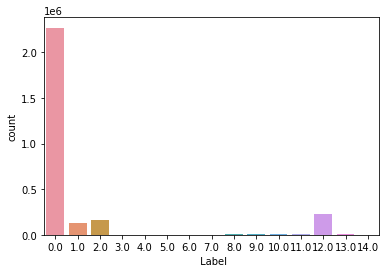

In [10]:
#Plot barchart
sns.countplot(df[' Label'])

In [20]:
 #Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

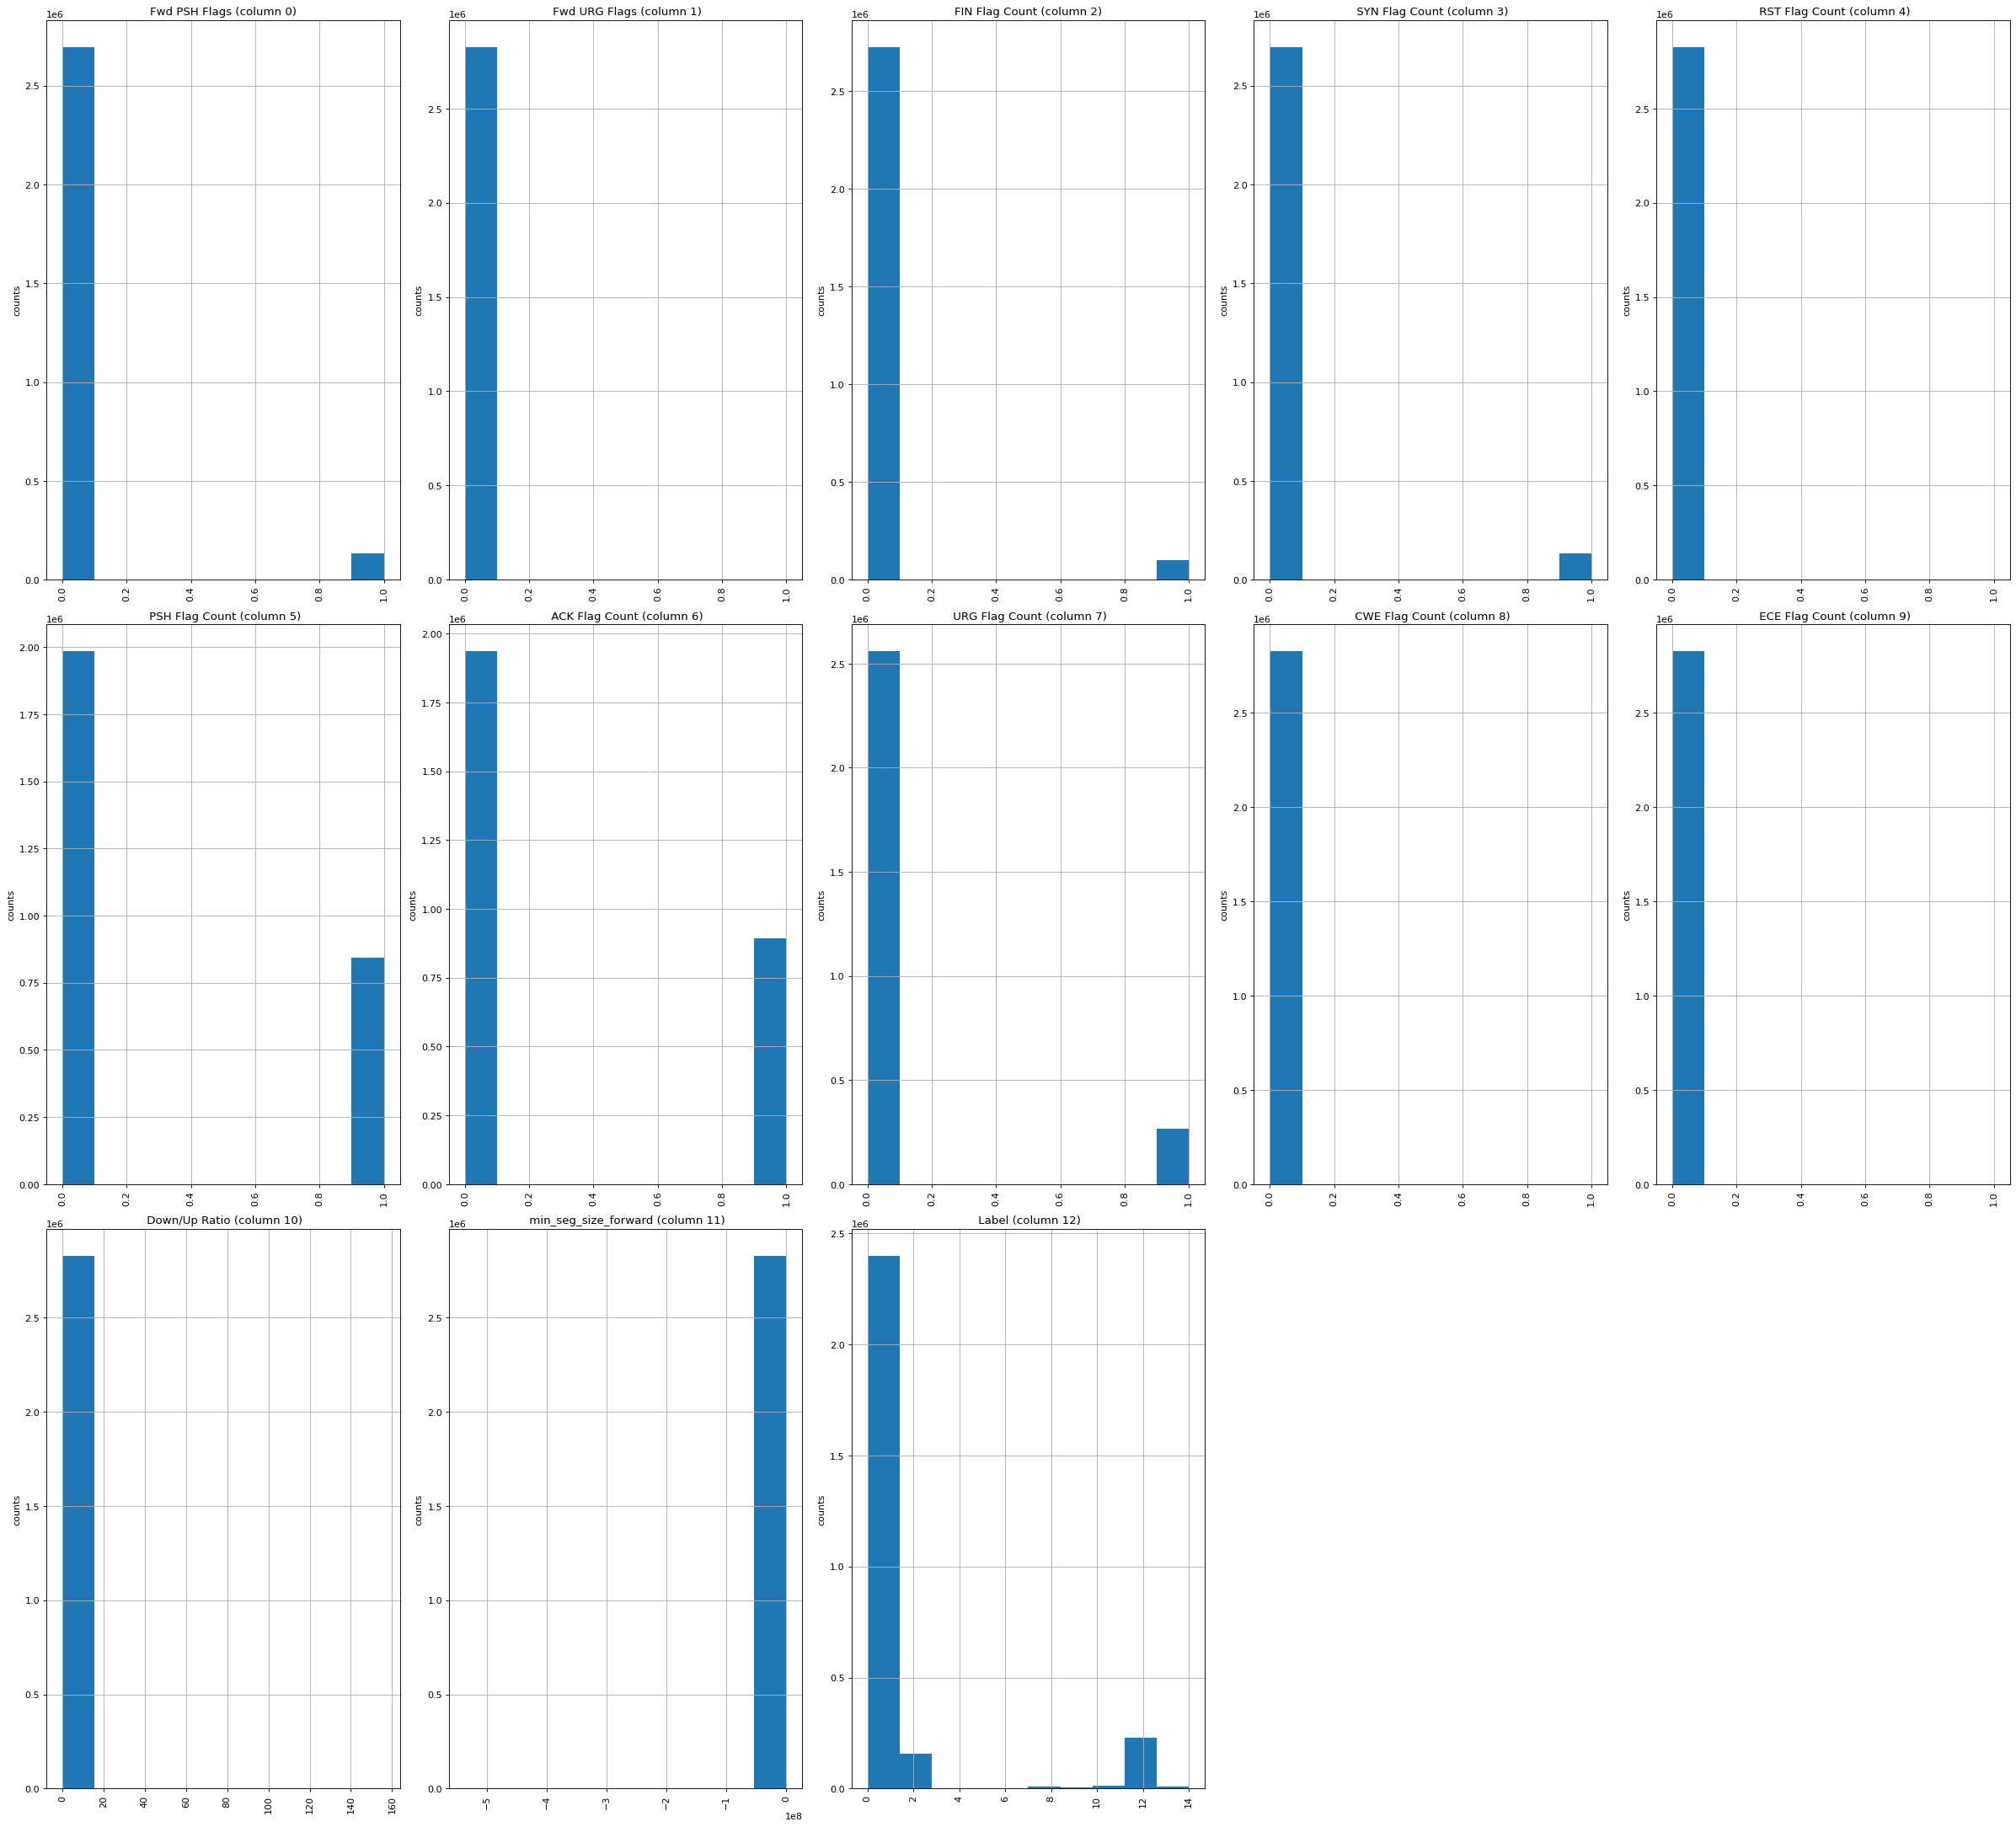

In [22]:
plotPerColumnDistribution(df, 20, 5)

In [11]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    #plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

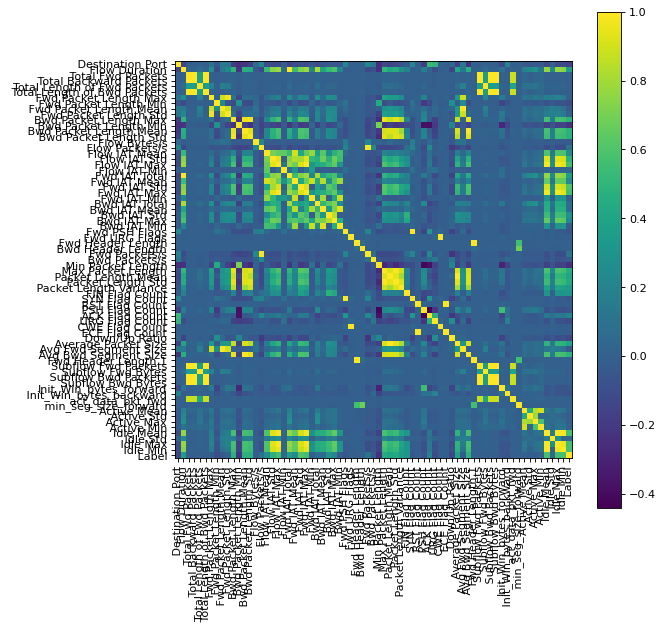

In [26]:
plotCorrelationMatrix(df, 8)

In [27]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

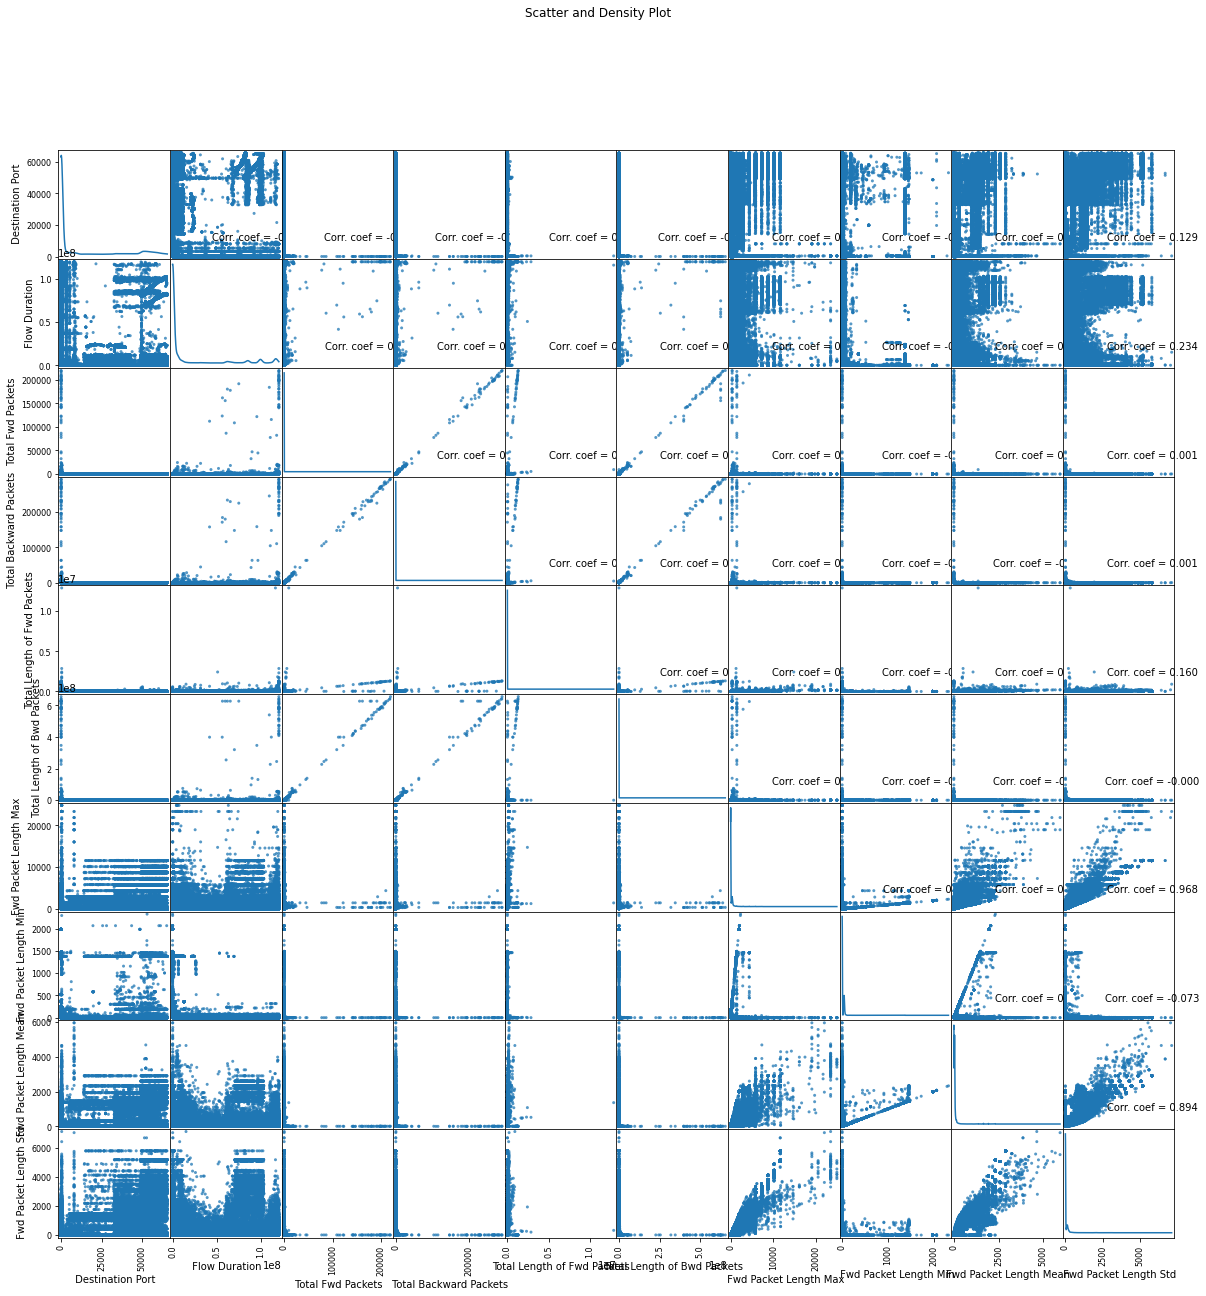

In [28]:
plotScatterMatrix(df, 20, 10)

In [ ]:
X = df.sample(frac=1.0, replace=False, random_state=1).drop([" Label"],axis=1)
y = df.sample(frac=1.0, replace=False, random_state=1)[' Label']

Feature selection using random regressor

In [ ]:
# Instantiate model with 200 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X, y);

In [ ]:
rf.feature_importances_

array([1.45481088e-01, 9.94519518e-04, 5.87445083e-04, 8.89651424e-04,
       2.54734799e-02, 4.72634001e-04, 1.13801992e-03, 9.97647039e-04,
       4.80917012e-04, 7.52641275e-02, 1.84756169e-04, 3.87469955e-05,
       2.62017197e-04, 4.72823550e-02, 1.06626546e-02, 1.82434483e-03,
       1.41692822e-03, 4.31598461e-04, 1.47404868e-03, 9.06361458e-04,
       6.84642890e-04, 7.94789091e-04, 1.49652156e-04, 6.36485147e-04,
       5.55884477e-03, 3.91462536e-05, 6.42990699e-04, 2.79254932e-05,
       4.70412491e-05, 7.50291355e-04, 1.52470901e-03, 0.00000000e+00,
       3.42117171e-06, 0.00000000e+00, 1.45445620e-04, 4.12273880e-04,
       4.74538422e-03, 7.24718097e-02, 5.49231581e-04, 3.09167531e-04,
       5.61194279e-03, 2.68796522e-04, 2.40021072e-04, 6.36799918e-03,
       1.62148476e-03, 1.79250961e-07, 4.78161737e-04, 2.58328669e-04,
       2.17630018e-04, 8.55823555e-07, 0.00000000e+00, 6.35818624e-05,
       8.02644844e-04, 4.97352497e-04, 2.45010685e-04, 1.80049032e-04,
      

In [ ]:
feature_list = list(df.columns)

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Idle Mean            Importance: 0.223
Variable:  Idle Min            Importance: 0.19
Variable:  Destination Port    Importance: 0.145
Variable:  Fwd Packet Length Std Importance: 0.075
Variable:  Bwd Packets/s       Importance: 0.072
Variable:  Init_Win_bytes_backward Importance: 0.07
Variable:  Bwd Packet Length Std Importance: 0.047
Variable: Init_Win_bytes_forward Importance: 0.034
Variable:  min_seg_size_forward Importance: 0.029
Variable: Total Length of Fwd Packets Importance: 0.025
Variable:  Subflow Fwd Bytes   Importance: 0.023
Variable: Flow Bytes/s         Importance: 0.011
Variable:  Fwd IAT Min         Importance: 0.006
Variable:  Packet Length Mean  Importance: 0.006
Variable: FIN Flag Count       Importance: 0.006
Variable: Fwd Packets/s        Importance: 0.005
Variable:  Active Std          Importance: 0.003
Variable:  Flow Packets/s      Importance: 0.002
Variable: Fwd PSH Flags        Importance: 0.002
Variable:  SYN Flag Count      Importance: 0.002
Vari

In [ ]:
#feature_importances
to_drop = [value[0] for value in feature_importances if (value[1]< 0.01)]

In [ ]:
to_drop

[' Fwd IAT Min',
 ' Packet Length Mean',
 'FIN Flag Count',
 'Fwd Packets/s',
 ' Active Std',
 ' Flow Packets/s',
 'Fwd PSH Flags',
 ' SYN Flag Count',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Flow IAT Mean',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Max',
 ' Bwd IAT Mean',
 ' Bwd IAT Min',
 ' Min Packet Length',
 ' Average Packet Size',
 'Subflow Fwd Packets',
 ' Subflow Bwd Packets',
 'Active Mean',
 ' Active Max',
 ' Active Min',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Mean',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Flow IAT Std',
 ' Fwd IAT Std',
 'Bwd IAT Total',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Bwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 ' Max Packet Length',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' RST Flag Count',
 ' PSH Fla

In [14]:
df1 =  df.drop(to_drop, axis=1)
df1.shape

(2827876, 13)

In [ ]:
df1.head()

,Destination Port,Total Length of Fwd Packets,Fwd Packet Length Std,Bwd Packet Length Std,Flow Bytes/s,Bwd Packets/s,Subflow Fwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Idle Mean,Idle Min,Label
0,54865.0,12.0,0.0,0.0,4.000000e+06,0.000000,12.0,33.0,-1.0,20.0,0.0,0.0,0.0
1,55054.0,6.0,0.0,0.0,1.100917e+05,9174.311927,6.0,29.0,256.0,20.0,0.0,0.0,0.0
2,55055.0,6.0,0.0,0.0,2.307692e+05,19230.769230,6.0,29.0,256.0,20.0,0.0,0.0,0.0
3,46236.0,6.0,0.0,0.0,3.529412e+05,29411.764710,6.0,31.0,329.0,20.0,0.0,0.0,0.0
4,54863.0,12.0,0.0,0.0,4.000000e+06,0.000000,12.0,32.0,-1.0,20.0,0.0,0.0,0.0


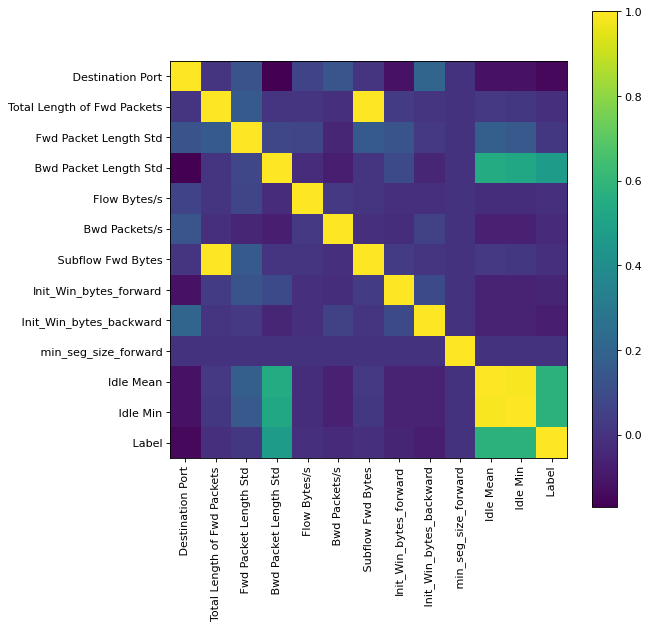

In [15]:
plotCorrelationMatrix(df1, 8)